In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import mplhep
plt.style.use(mplhep.style.LHCb2)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
import pickle
from scipy.stats import norm
import ROOT
import matplotlib.ticker as mtick


Welcome to JupyROOT 6.26/00


In [2]:
df = pd.read_pickle("/mnt/ssd/users/wenjiewu/flare_data/g4sim_ana_data/20221202_genie_v306_evt30000/features_geniev306_trueDirection.pkl")  

In [3]:
weight = []
for event_id, df_event in df.groupby('uniqueid', sort=False):
    #_weight = (0.47 if df_event['nuPDG'].iloc[0]==12 else (2.62 if df_event['nuPDG'].iloc[0]==14 else 0.02)) # for 100000 events of each flavor
    _weight = (4.7 if df_event['nuPDG'].iloc[0]==12 else (26.2 if df_event['nuPDG'].iloc[0]==14 else 0.2))/3 # for 30000 events of each flavor
    weight.extend([_weight] * df_event.shape[0])
df['weight'] = weight

In [4]:
tauDecayMode = []
for event_id, df_event in df.groupby('uniqueid', sort=False):
    tauDecayPDGList = df_event.query('nuPDG==16 and nuIntType==2 and primaryParentID==1')['primaryTrackPDG'].to_numpy()
    if 11 in tauDecayPDGList:
        _tauDecayMode = 1
    elif 13 in tauDecayPDGList:
        _tauDecayMode = 2
    elif -211 in tauDecayPDGList:
        _tauDecayMode = 3
    else:
        _tauDecayMode = 0
    tauDecayMode.extend([_tauDecayMode] * df_event.shape[0])
df['tauDecayMode'] = tauDecayMode

* nuIntType: https://internal.dunescience.org/doxygen/Generator_2src_2Framework_2Interaction_2InteractionType_8h.html
|0|1|2|3|
|:-:|:-:|:-:|:-:|
|Null|IntEM|WeakCC|WeakNC|

* nuScatteringType: https://internal.dunescience.org/doxygen/ScatteringType_8h.html
|0|1|2|3|4|7|
|:-:|:-:|:-:|:-:|:-:|:-:|
|Null|QE|SingleKaon|DIS|RES|NuElectronElastic|

In [5]:
df.keys()[0:50]

Index(['nuIdx', 'nuPDG', 'nuX', 'nuY', 'nuZ', 'nuE', 'nuIntType',
       'nuScatteringType', 'nuFSLPDG', 'nuFSLPx', 'nuFSLPy', 'nuFSLPz',
       'nuFSLE', 'nPrimaryParticle', 'primaryTrackPDG', 'Px', 'Py', 'Pz',
       'Pmass', 'VtxX', 'VtxY', 'VtxZ', 'primaryParentID', 'primaryTrackID',
       'prongType', 'prongIndex', 'primaryTrackLength',
       'primaryTrackLengthInTPC', 'EInDetector', 'EInLAr', 'EInHadCal',
       'EInMuonFinder', 'EInMuonFinderLayer1X', 'EInMuonFinderLayer1Y',
       'EInMuonFinderLayer2X', 'EInMuonFinderLayer2Y', 'AngleToBeamDir',
       'ShowerLength', 'ShowerLengthInLAr', 'ShowerWidth', 'ShowerWidthInLAr',
       'dEdx', 'dEdxInLAr', 'edepInLAr', 'edepInHadCalX', 'edepInHadCalY',
       'edepInMuonFinderX', 'edepInMuonFinderY', 'edepInHadAborb',
       'edepInMuonFinderAbsorb'],
      dtype='object')

In [6]:
df.query('primaryParentID==1 and uniqueid==60007')[['uniqueid', 'nuPDG', 'nuIntType', 'primaryTrackPDG', 'tauDecayMode']]

,uniqueid,nuPDG,nuIntType,primaryTrackPDG,tauDecayMode
1265252,60007,16,2,11,1
1265253,60007,16,2,-12,1
1265254,60007,16,2,16,1


In [7]:
df_event = df.query('prongIndex==1')[['uniqueid', 'nuIdx', 'nuPDG', 'nuX', 'nuY', 'nuZ', 'nuE', 'nuIntType', 'nuScatteringType', 'nuFSLPDG', 'nuFSLE', 'weight',
                                    'tauDecayMode', 'num_piminus', 'leading_piminus_momentum', 'leading_piminus_showerlength', 'leading_piminus_edep',
                                    'first_closest_shower_to_leading_piminus_angle', 'first_closest_shower_to_leading_piminus_showerlength', 
                                    'first_closest_shower_to_leading_piminus_edep', 'second_closest_shower_to_leading_piminus_angle', 
                                    'second_closest_shower_to_leading_piminus_showerlength', 'second_closest_shower_to_leading_piminus_edep',
                                    'third_closest_shower_to_leading_piminus_angle', 'third_closest_shower_to_leading_piminus_showerlength', 
                                    'third_closest_shower_to_leading_piminus_edep', 'fourth_closest_shower_to_leading_piminus_angle', 
                                    'fourth_closest_shower_to_leading_piminus_showerlength', 'fourth_closest_shower_to_leading_piminus_edep']]
df_event[['LongestProngPDG', 'LongestEInLAr', 'LongestEInHadCal', 'LongestEInMuonFinder',  'LongestdEdxInLAr', 'Pt', 'LongestProngType', 'LongestShowerLength',
          'LongestEInMuonFinderLayer1X', 'LongestEInMuonFinderLayer1Y', 'LongestEInMuonFinderLayer2X', 'LongestEInMuonFinderLayer2Y']]  \
                                                                              = df.query('prongIndex == longestProngIdx')[['primaryTrackPDG', 
                                                                                                                         'EInLAr', 
                                                                                                                         'EInHadCal', 
                                                                                                                         'EInMuonFinder', 
                                                                                                                         'dEdxInLAr', 
                                                                                                                         'Pt', 
                                                                                                                         'prongType',
                                                                                                                         'ShowerLength',
                                                                                                                         'EInMuonFinderLayer1X',
                                                                                                                         'EInMuonFinderLayer1Y',
                                                                                                                         'EInMuonFinderLayer2X',
                                                                                                                         'EInMuonFinderLayer2Y']].to_numpy()
df_event[['LeadingEInHadCal', 'LeadingEInMuonFinder', 'LeadingdEdxInLAr']] = df.query('prongIndex == leadingProngIdx')[['EInHadCal', 
                                                                                                                      'EInMuonFinder', 
                                                                                                                      'dEdxInLAr']].to_numpy()

df_event.eval('first_closest_shower_to_leading_piminus_showerlength_frac=first_closest_shower_to_leading_piminus_showerlength/leading_piminus_showerlength', inplace=True)
df_event.eval('first_closest_shower_to_leading_piminus_edep_frac=first_closest_shower_to_leading_piminus_edep/leading_piminus_edep', inplace=True)
df_event.eval('second_closest_shower_to_leading_piminus_showerlength_frac=second_closest_shower_to_leading_piminus_showerlength/leading_piminus_showerlength', inplace=True)
df_event.eval('second_closest_shower_to_leading_piminus_edep_frac=second_closest_shower_to_leading_piminus_edep/leading_piminus_edep', inplace=True)
df_event.eval('third_closest_shower_to_leading_piminus_showerlength_frac=third_closest_shower_to_leading_piminus_showerlength/leading_piminus_showerlength', inplace=True)
df_event.eval('third_closest_shower_to_leading_piminus_edep_frac=third_closest_shower_to_leading_piminus_edep/leading_piminus_edep', inplace=True)
df_event.eval('fourth_closest_shower_to_leading_piminus_showerlength_frac=fourth_closest_shower_to_leading_piminus_showerlength/leading_piminus_showerlength', inplace=True)
df_event.eval('fourth_closest_shower_to_leading_piminus_edep_frac=fourth_closest_shower_to_leading_piminus_edep/leading_piminus_edep', inplace=True)
df_event.eval('leading_piminus_edep=leading_piminus_edep/1000', inplace=True)
df_event.eval('allMuonFinderLayers = LongestEInMuonFinderLayer1X>0 and LongestEInMuonFinderLayer1Y>0 and LongestEInMuonFinderLayer2X>0 and LongestEInMuonFinderLayer2Y>0', inplace=True)


In [8]:
def plot_comparison(var, varlabel, df1, df2, labels, ranges, Nbins=40, density=1):
    hsig, bins = np.histogram(df1[var], bins=Nbins, range=ranges)
    hbkg, bins = np.histogram(df2[var], bins=bins)
    print("Number of signal and background : ", np.sum(hsig), np.sum(hbkg))
    mplhep.histplot((hsig, bins), label=labels[0], yerr=True, density=density)
    mplhep.histplot(hbkg, bins, label=labels[1], yerr=True, density=density)
    plt.xlabel(varlabel)
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc='best', frameon=True)
    
def plot_comparison_with_weight(var, varlabel, df1, df2, labels, norm, ranges, Nbins=40, density=1):
    hsig, bins = np.histogram(df1[var], bins=Nbins, weights=df1['weight']*norm[0], range=ranges)
    hbkg, bins = np.histogram(df2[var], bins=bins, weights=df2['weight']*norm[1])
    herr_sig = np.sqrt(np.histogram(df1[var], bins=bins, weights=(df1['weight']*norm[0])**2, range=ranges)[0])
    herr_bkg = np.sqrt(np.histogram(df2[var], bins=bins, weights=(df2['weight']*norm[1])**2, range=ranges)[0])
    print("Number of signal and background : ", np.sum(hsig), np.sum(hbkg))
    mplhep.histplot((hsig, bins), label=labels[0], yerr=herr_sig, density=density)
    mplhep.histplot(hbkg, bins, label=labels[1], yerr=herr_bkg, density=density)
    plt.xlabel(varlabel)
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc='best', frameon=True)
    
def plot_comparisons_with_weights(var, varlabel, dfs, labels, norms, ranges, Nbins=40, density=1):
    hcontents = []; bins = [];
    for df, label, norm in zip(dfs, labels, norms):
        h, b = np.histogram(df[var], bins=Nbins, weights=df['weight']*norm, range=ranges)
        herr = np.sqrt(np.histogram(df[var], bins=b, weights=(df['weight']*norm)**2, range=ranges)[0])
        hcontents.append(h); bins.append(b);
        mplhep.histplot((h, b), label=label, yerr=herr, density=density)
    print("number of events : ", [np.sum(hsig) for hsig in hcontents])
    plt.xlabel(varlabel)
    plt.xlim(bins[0][0], bins[0][-1])
    plt.legend(loc='best', frameon=True)

In [9]:
numucc = df_event.query('nuPDG==14 & nuIntType==2')
numunc = df_event.query('nuPDG==14 & nuIntType==3')
nuecc = df_event.query('nuPDG==12 & nuIntType==2')
nuenc = df_event.query('nuPDG==12 & nuIntType==3')
nutau_e = df_event.query('tauDecayMode==1')
nutau_mu = df_event.query('tauDecayMode==2')
nutau_had = df_event.query('tauDecayMode==3')
nutau_nc = df_event.query('nuPDG==16 & nuIntType==3')
nc = pd.concat([nuenc,numunc,nutau_nc])
numu = pd.concat([numucc, numunc])

In [47]:
values, counts = np.unique(df.query('nuPDG==16 and nuIntType==3')['primaryTrackPDG'].to_numpy(), return_counts=True)

#print(values, counts, np.sum(counts))

print([(_, '{:.2f}%'.format(x/np.sum(counts)*100)) for _, x in sorted(zip(values, counts), key=lambda pair: pair[1], reverse=True)])

[(22, '29.38%'), (111, '13.81%'), (-211, '12.62%'), (211, '12.15%'), (2112, '10.51%'), (2212, '10.05%'), (16, '4.99%'), (321, '1.27%'), (311, '1.22%'), (-321, '1.03%'), (-311, '0.95%'), (3122, '0.61%'), (-2112, '0.45%'), (-2212, '0.43%'), (11, '0.17%'), (-11, '0.17%'), (-3122, '0.14%'), (130, '0.04%'), (1000180400, '0.00%'), (3112, '0.00%'), (-13, '0.00%'), (13, '0.00%'), (3222, '0.00%')]


number of events :  [28444.400000002, 183862.8666666841, 68800.0, 79660.0, 233380.0, 55261.699999996024]
number of events :  [35944.0333333334, 201076.2666666658, 88880.0, 87420.0, 269860.0, 72456.23333333325]


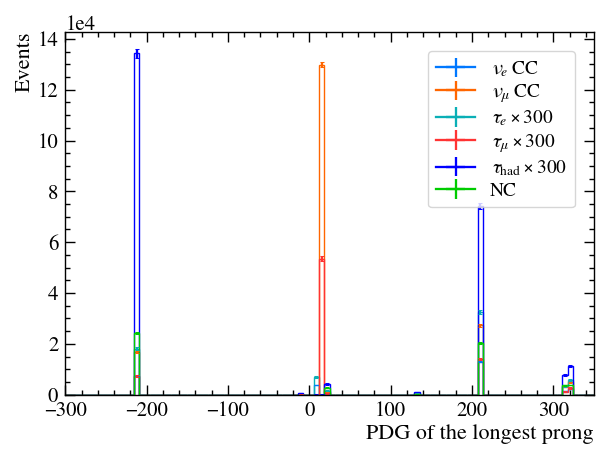

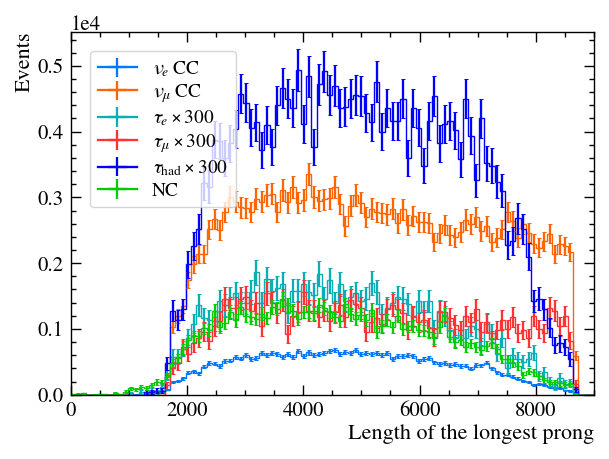

In [48]:
plt.figure(dpi=50)
plot_comparisons_with_weights('LongestProngPDG', 'PDG of the longest prong', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [-300,350], Nbins=100, density=0) 
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
plt.ylabel('Events')
plt.gcf().savefig('pics/LongestProngPDG.pdf')

plt.figure(dpi=50)
plot_comparisons_with_weights('LongestShowerLength', 'Length of the longest prong', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [0,9000], Nbins=100, density=0) 
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
plt.ylabel('Events')
plt.gcf().savefig('pics/LongestProngLength.pdf')


number of events :  [35944.03333333769, 201076.2666667094, 88860.0, 87420.0, 269880.0, 72473.69999998902]


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Text(0, 1, 'Events')

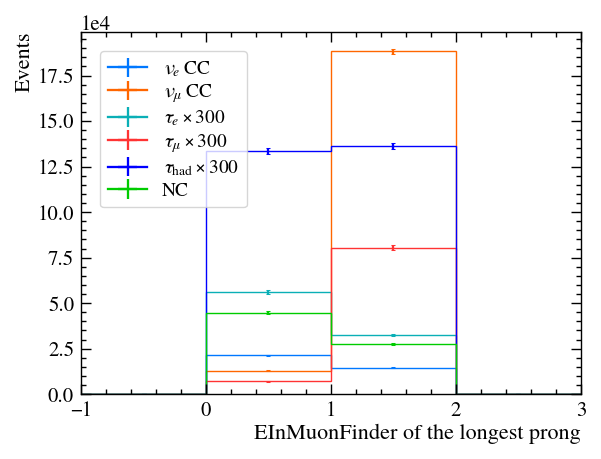

In [61]:
plt.figure(dpi=50)
plot_comparisons_with_weights('allMuonFinderLayers', 'EInMuonFinder of the longest prong', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [-1,3], Nbins=4, density=0) 
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
plt.ylabel('Events')
#plt.gcf().savefig('pics/LongestProngLength.pdf')

In [66]:
df.keys()

Index(['nuIdx', 'nuPDG', 'nuX', 'nuY', 'nuZ', 'nuE', 'nuIntType',
       'nuScatteringType', 'nuFSLPDG', 'nuFSLPx', 'nuFSLPy', 'nuFSLPz',
       'nuFSLE', 'nPrimaryParticle', 'primaryTrackPDG', 'Px', 'Py', 'Pz',
       'Pmass', 'VtxX', 'VtxY', 'VtxZ', 'primaryParentID', 'primaryTrackID',
       'prongType', 'primaryTrackLength', 'primaryTrackLengthInTPC', 'EInLAr',
       'EInHadCal', 'EInMuonFinder', 'EInMuonFinderLayer1X',
       'EInMuonFinderLayer1Y', 'EInMuonFinderLayer2X', 'EInMuonFinderLayer2Y',
       'AngleToBeamDir', 'ShowerLength', 'ShowerLengthInLAr', 'ShowerWidth',
       'ShowerWidthInLAr', 'dEdx', 'dEdxInLAr', 'edepInLAr', 'edepInHadCalX',
       'edepInHadCalY', 'edepInMuonFinderX', 'edepInMuonFinderY',
       'edepInHadAborb', 'edepInMuonFinderAbsorb', 'edepInCryGap',
       'nFromFSLParticles', 'nFromFSLParticles', 'dir_pol_x', 'dir_pol_y',
       'dir_pol_z', 'dir_coc_x', 'dir_coc_y', 'dir_coc_z', 'uniqueid', 'TrueP',
       'edep_tot', 'edep_prong', 'fsl_EInLArFrac'

In [79]:
df.query('nuPDG==16 and nuIntType==2 and nuIdx==8')[['prongIdx', 'ShowerLength', 'ShowerWidth', 'primaryTrackPDG', 'longestProng', 'leadingProng']]

,prongIdx,ShowerLength,ShowerWidth,primaryTrackPDG,longestProng,leadingProng
915862,1,27.605065,1.602306,2212,3959.931282,20875.192991
915863,2,524.147873,72.750666,211,3959.931282,20875.192991
915864,3,2901.157715,1284.526072,2212,3959.931282,20875.192991
915865,4,2724.977965,1395.365399,111,3959.931282,20875.192991
915866,5,3006.037417,1639.306437,211,3959.931282,20875.192991
915867,6,3125.692315,1571.567386,-211,3959.931282,20875.192991
915868,7,2542.292617,859.355048,111,3959.931282,20875.192991
915869,8,3778.525423,1510.819244,321,3959.931282,20875.192991
915870,9,2663.034523,1121.277838,111,3959.931282,20875.192991
915871,10,3007.215773,1788.502801,-321,3959.931282,20875.192991


In [87]:
df.query('uniqueid==3879')[['primaryTrackPDG', 'Px', 'Py', 'Pz', 'ShowerWidth', 'ShowerLength']]

,primaryTrackPDG,Px,Py,Pz,ShowerWidth,ShowerLength
59909,2212,41.655438,149.992976,1035.146467,587.826850,782.352821
59910,-211,103.214212,-178.125418,-216.217021,359.652997,904.988988
59911,211,-657.406526,723.708958,3612.909834,1331.315865,1821.929560
59912,111,-659.313625,-150.857849,1590.751035,899.990988,1766.949839
59913,2212,756.868956,63.270758,3954.809478,1334.654671,2889.289550
59914,111,-3438.553364,1680.867929,61358.689685,1388.371867,3977.354901
59915,-211,-549.972681,434.199630,5166.114114,1193.684465,3014.555337
59916,111,-3696.623106,2332.549206,69359.010377,1204.741899,4790.458012
59917,-13,-26.179277,-108.229503,2409.604265,519.985235,6708.733291
59918,13,-143.570738,68.954754,747.420448,650.364705,2851.938039


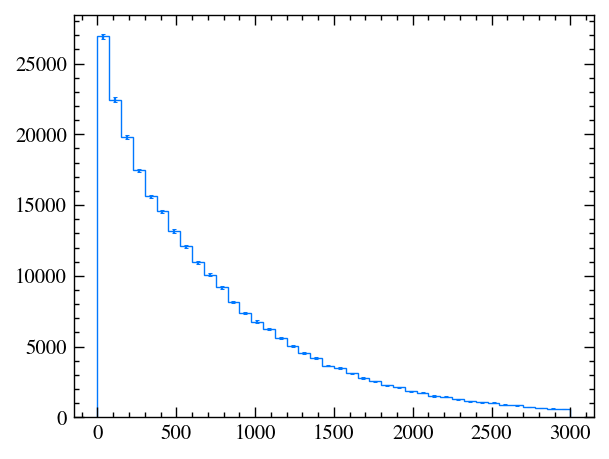

In [5]:
#fig, ax = plt.subplots(figsize=(8,6))
plt.figure(dpi=50)
h, b = np.histogram(df.query('primaryTrackPDG==211')['primaryTrackLength'], bins=40, range=(0,3000))
mplhep.histplot((h, b), label='nuE', yerr=True, density=0)
#plt.gca().set_yscale('log')
#plt.text(0.6,0.7,r'Mean: {:.1f} GeV'.format(np.mean(numu['nuE'])),fontsize=30,transform=plt.gca().transAxes)
#plt.gca().set_xlabel(r'$E_\nu$ [GeV]')
#plt.gcf().savefig('pics_numu/numu_nu_energy.pdf')
plt.show()

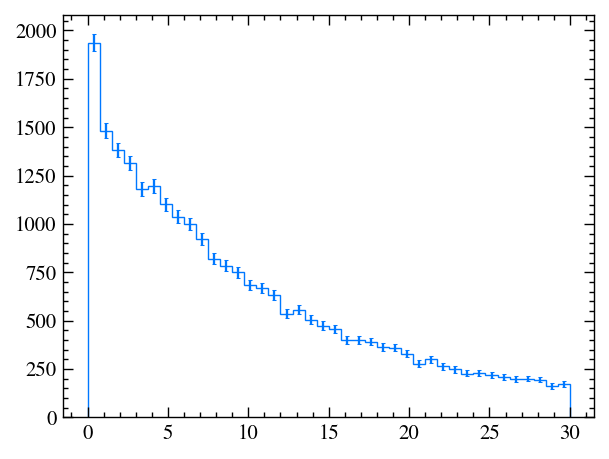

In [8]:
#fig, ax = plt.subplots(figsize=(8,6))
plt.figure(dpi=50)
h, b = np.histogram(df.query('primaryTrackPDG==13')['ShowerWidthInLAr'], bins=40, range=(0,30))
mplhep.histplot((h, b), label='nuE', yerr=True, density=0)
#plt.text(0.6,0.7,r'Mean: {:.1f} GeV'.format(np.mean(numu['nuE'])),fontsize=30,transform=plt.gca().transAxes)
#plt.gca().set_xlabel(r'$E_\nu$ [GeV]')
#plt.gcf().savefig('pics_numu/numu_nu_energy.pdf')
plt.show()

number of events :  [30360.433333333283, 161619.06666666386, 77240.0, 74240.0, 219700.0, 62049.5666666559]


Text(0, 1, 'Events')

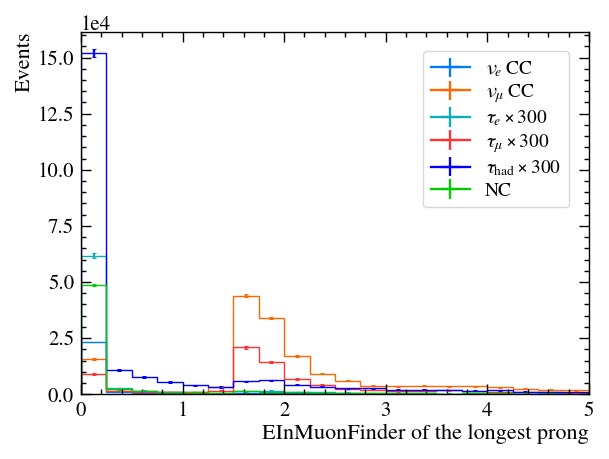

In [37]:
plt.figure(dpi=50)
plot_comparisons_with_weights('LongestEInMuonFinderLayer2X', 'EInMuonFinder of the longest prong', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [0,5], Nbins=20, density=0) 
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
plt.ylabel('Events')
#plt.gcf().savefig('pics/LongestProngLength.pdf')

number of events :  [10451.233333333359, 165452.99999999994, 27760.0, 71320.0, 78960.0, 25908.199999999906]
number of events :  [16915.29999999984, 155724.06666666854, 46180.0, 66040.0, 103860.0, 38279.29999999864]
number of events :  [30957.33333333564, 178439.46666666132, 78700.0, 79240.0, 224880.0, 62993.53333332608]
number of events :  [10181.76666666668, 171051.06666666592, 27600.0, 72060.0, 77200.0, 25323.699999999906]
number of events :  [35942.466666670996, 201058.79999998788, 78160.0, 75140.0, 260560.0, 48206.799999999785]


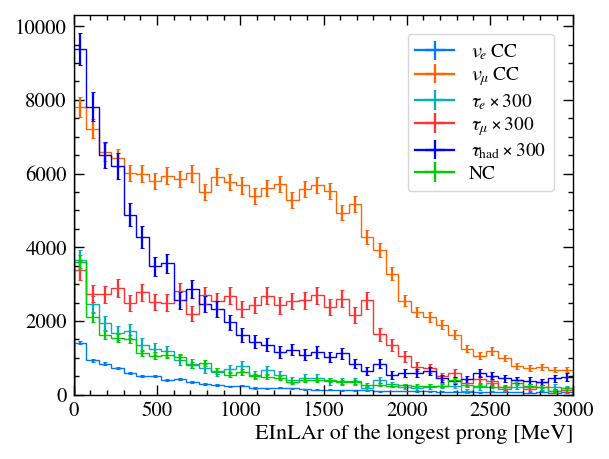

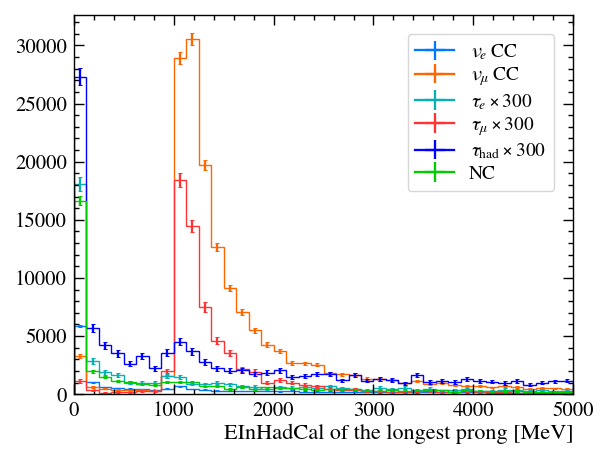

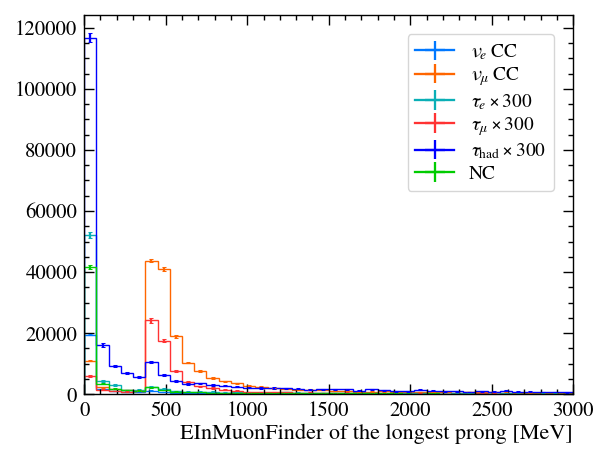

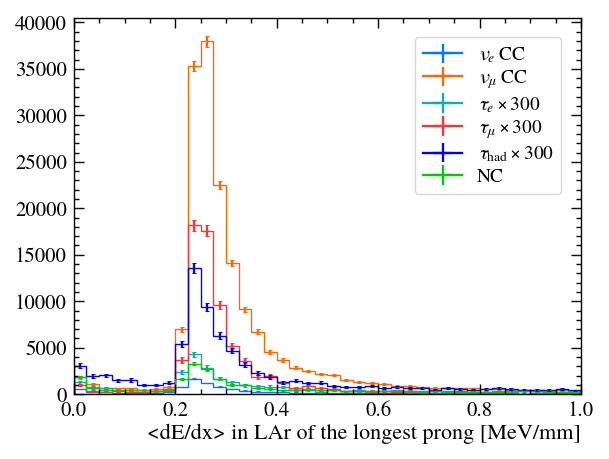

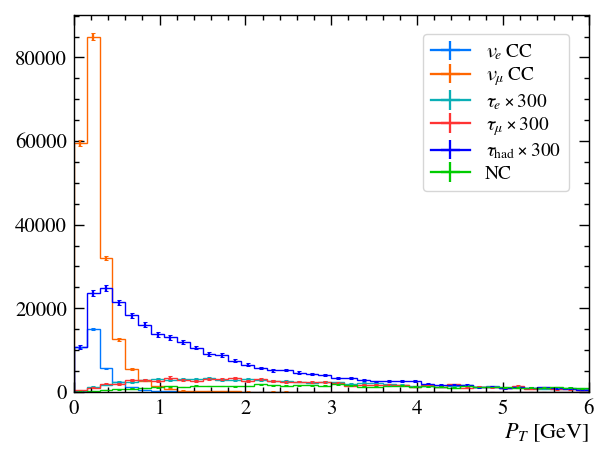

In [36]:
plt.figure(dpi=50)
plot_comparisons_with_weights('LongestEInLAr', 'EInLAr of the longest prong [MeV]', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [0, 3000], density=0) 
plt.gcf().savefig('pics/LongestEInLAr.pdf')

plt.figure(dpi=50)
plot_comparisons_with_weights('LongestEInHadCal', 'EInHadCal of the longest prong [MeV]', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [0, 5000], density=0) 
plt.gcf().savefig('pics/LongestEInHadCal.pdf')

plt.figure(dpi=50)
plot_comparisons_with_weights('LongestEInMuonFinder', 'EInMuonFinder of the longest prong [MeV]', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [0, 3000], density=0) 
plt.gcf().savefig('pics/LongestEInMuonFinder.pdf')

plt.figure(dpi=50)
plot_comparisons_with_weights('LongestdEdxInLAr', '<dE/dx> in LAr of the longest prong [MeV/mm]', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [0, 1], density=0) 
plt.gcf().savefig('pics/LongestdEdxInLAr.pdf')

plt.figure(dpi=50)
plot_comparisons_with_weights('Pt', r'$P_T$ [GeV]', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [0, 6], density=0) 
plt.gcf().savefig('pics/Pt.pdf')

In [ ]:
plt.figure(dpi=50)
plot_comparisons_with_weights('num_piminus', r'Number of $\pi^{-}$ in the final state', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [-1, 10], Nbins=11, density=0) 
plt.gcf().savefig('pics/num_piminus.pdf')

plt.figure(dpi=50)
plot_comparisons_with_weights('leading_piminus_momentum', r'$P_{\pi^{-}_{\mathrm{leading}}}$ [GeV]', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [0, 200], density=0) 
plt.gcf().savefig('pics/leading_piminus_momentum.pdf')

plt.figure(dpi=50)
plot_comparisons_with_weights('leading_piminus_edep', r'$E^{\mathrm{dep}}_{\pi^{-}_{\mathrm{leading}}}$ [GeV]', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [0, 200], density=0) 
plt.gcf().savefig('pics/leading_piminus_edep.pdf')

plt.figure(dpi=50)
plot_comparisons_with_weights('leading_piminus_showerlength', r'$L_{\pi^{-}_{\mathrm{leading}}}$ [mm]', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [0, 200], density=0) 
plt.gcf().savefig('pics/leading_piminus_edep.pdf')

plt.figure(dpi=50)
plot_comparison_with_weight('leading_piminus_showerlength', r'$L_{\pi^{-}_{\mathrm{leading}}}$ [mm]', tau_had, not_tau_had, [r'$\tau_{\mathrm{had}}\times300$', 'others'], 
                            [300, 1], [0, 9600], density=0)
plt.gcf().savefig('tau_had_pics/leading_piminus_showerlength.pdf')


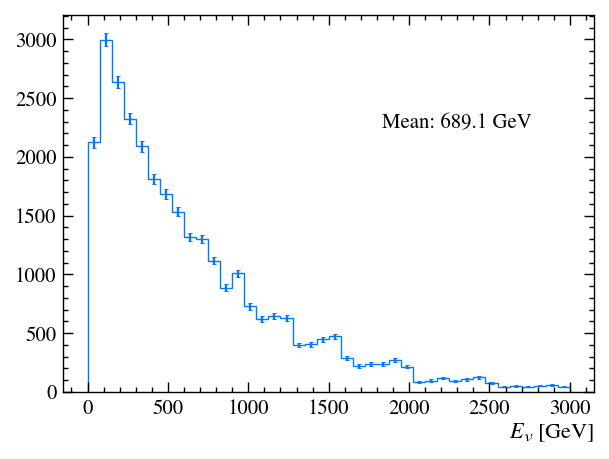

In [14]:
#fig, ax = plt.subplots(figsize=(8,6))
plt.figure(dpi=50)
h, b = np.histogram(numu['nuE'], bins=40, range=(0,3000))
mplhep.histplot((h, b), label='nuE', yerr=True, density=0)
plt.text(0.6,0.7,r'Mean: {:.1f} GeV'.format(np.mean(numu['nuE'])),fontsize=30,transform=plt.gca().transAxes)
plt.gca().set_xlabel(r'$E_\nu$ [GeV]')
plt.gcf().savefig('pics_numu/numu_nu_energy.pdf')
plt.show()

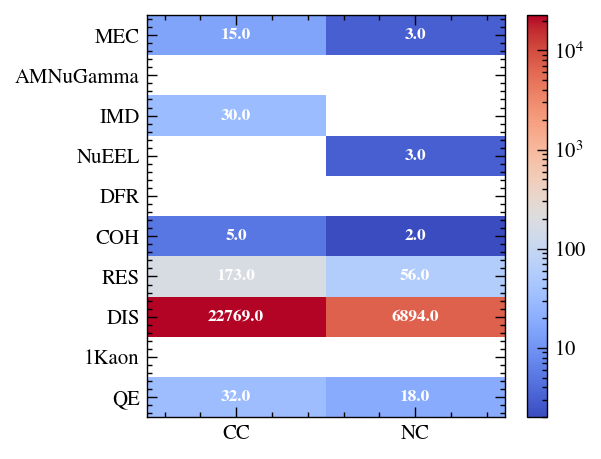

In [40]:
#fig, ax = plt.subplots(figsize=(8,6))
plt.figure(dpi=50)
plt.subplots_adjust(left=0.1)
hist, xbins, ybins, im = plt.hist2d(numu['nuIntType'], numu['nuScatteringType'], 
                                    bins=[np.arange(2,5), np.arange(1,12)], norm=mpl.colors.LogNorm(), cmap=plt.cm.coolwarm)
plt.gca().set_xticks(np.linspace(2.5, 3.5, 2), labels=['CC', 'NC'])
plt.gca().set_yticks(np.linspace(1.5, 10.5, 10), labels=['QE', '1Kaon', 'DIS', 'RES', 'COH', 'DFR', 'NuEEL', 'IMD', 'AMNuGamma', 'MEC'])
#plt.gca().set_xlabel('CCNC'); plt.gca().set_ylabel('IntMode')
plt.colorbar()
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        plt.gca().text(xbins[j]+0.5,ybins[i]+0.5, hist.T[i,j], 
                color="w", ha="center", va="center", fontweight="bold", fontsize=25)
plt.gcf().savefig('pics_numu/numu_nu_intType.pdf')
plt.show()

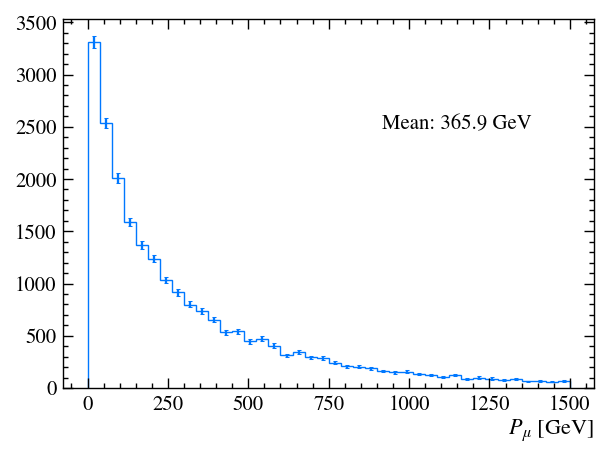

In [9]:
plt.figure(dpi=50)
h, b = np.histogram(df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1')['TrueP']/1000, bins=40, range=(0,1500))
mplhep.histplot((h, b), label='Pmu', yerr=True, density=0)
plt.text(0.6,0.7,r'Mean: {:.1f} GeV'.format(np.mean(df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1')['TrueP']/1000)),fontsize=30,transform=plt.gca().transAxes)
plt.gca().set_xlabel(r'$P_\mu$ [GeV]')
plt.gcf().savefig('pics_numu/numucc_lepton_momentum.pdf')
plt.show()

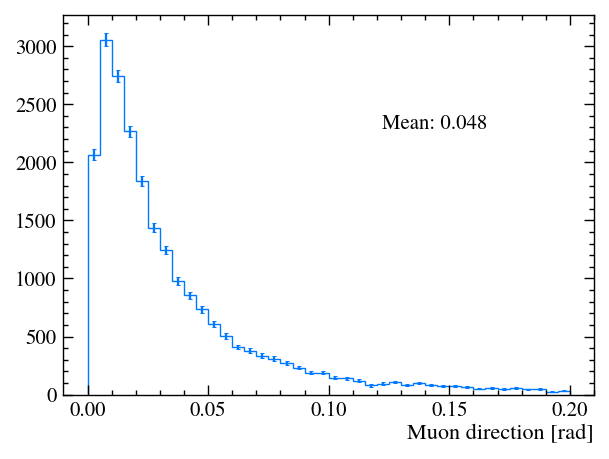

In [10]:
plt.figure(dpi=50)
h, b = np.histogram(df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1')['AngleToBeamDir'], bins=40, range=(0,0.2))
mplhep.histplot((h, b), label='lepton_dir', yerr=True, density=0)
plt.text(0.6,0.7,r'Mean: {:.3f}'.format(np.mean(df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1')['AngleToBeamDir'])),
         fontsize=30,transform=plt.gca().transAxes)
plt.gca().set_xlabel(r'Muon direction [rad]')
plt.gcf().savefig('pics_numu/numucc_lepton_dir.pdf')
plt.show()


In [24]:
print(df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1 and arctan((1000-sqrt(VtxX*VtxX+VtxY*VtxY))/(35700-VtxZ))>AngleToBeamDir').shape[0]/df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1').shape[0])
print(df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1 and arctan((1000-sqrt(VtxX*VtxX+VtxY*VtxY))/(35700-VtxZ))<=AngleToBeamDir').shape[0]/df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1').shape[0])


0.4168693537178596
0.5818276580959


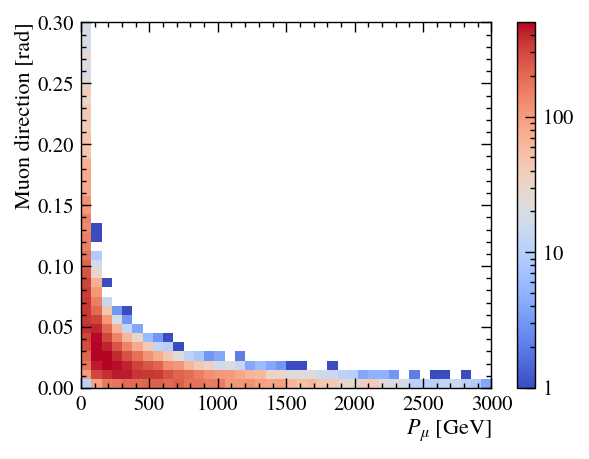

In [25]:
plt.figure(dpi=50)
plt.subplots_adjust(left=0.1)
hist, xbins, ybins, im = plt.hist2d(df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1')['TrueP']/1000, 
                                    df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1')['AngleToBeamDir'],
                                    range=[[0,3000],[0,0.3]], bins=[40, 40], norm=mpl.colors.LogNorm(), cmap=plt.cm.coolwarm)
plt.gca().set_xlabel(r'$P_{\mu}$ [GeV]')
plt.gca().set_ylabel('Muon direction [rad]')
plt.colorbar()
plt.gcf().savefig('pics_numu/numucc_lepton_momentum_dir.pdf')
plt.show()

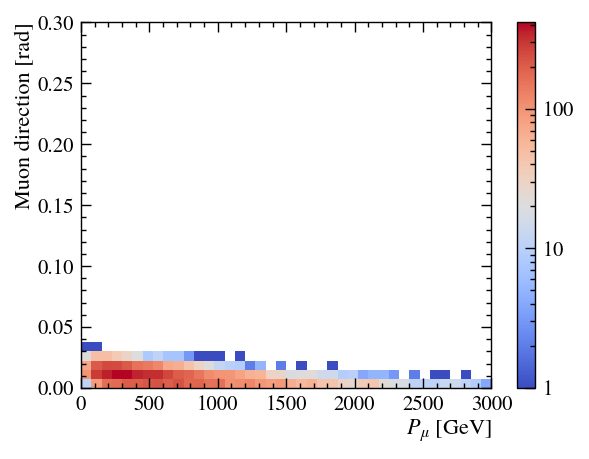

In [26]:
plt.figure(dpi=50)
plt.subplots_adjust(left=0.1)
plt.hist2d(df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1 and arctan((1000-sqrt(VtxX*VtxX+VtxY*VtxY))/(35700-VtxZ))>AngleToBeamDir')['TrueP']/1000,
           df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1 and arctan((1000-sqrt(VtxX*VtxX+VtxY*VtxY))/(35700-VtxZ))>AngleToBeamDir')['AngleToBeamDir'],
           range=[[0,3000],[0,0.3]], bins=[40, 40], norm=mpl.colors.LogNorm(), cmap=plt.cm.coolwarm)
plt.gca().set_xlabel(r'$P_{\mu}$ [GeV]')
plt.gca().set_ylabel('Muon direction [rad]')
plt.colorbar()
plt.gcf().savefig('pics_numu/numucc_accepted_lepton_momentum_dir.pdf')
plt.show()

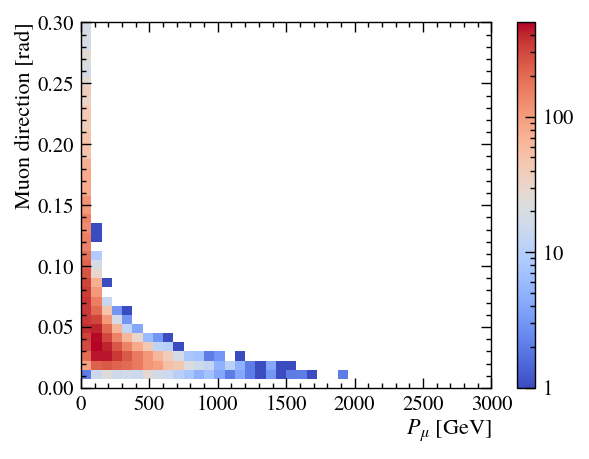

In [27]:
plt.figure(dpi=50)
plt.subplots_adjust(left=0.1)
plt.hist2d(df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1 and arctan((1000-sqrt(VtxX*VtxX+VtxY*VtxY))/(35700-VtxZ))<AngleToBeamDir')['TrueP']/1000,
           df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1 and arctan((1000-sqrt(VtxX*VtxX+VtxY*VtxY))/(35700-VtxZ))<AngleToBeamDir')['AngleToBeamDir'],
           range=[[0,3000],[0,0.3]], bins=[40, 40], norm=mpl.colors.LogNorm(), cmap=plt.cm.coolwarm)
plt.gca().set_xlabel(r'$P_{\mu}$ [GeV]')
plt.gca().set_ylabel('Muon direction [rad]')
plt.colorbar()
plt.gcf().savefig('pics_numu/numucc_unaccepted_lepton_momentum_dir.pdf')
plt.show()

In [18]:
numucc_true_had_E = df.query('nuPDG==14 and nuIntType==2 and prongIdx==1').eval('nuE-nuFSLE').to_numpy()*1000
numucc_deposited_had_E = df.query('nuPDG==14 and nuIntType==2 and prongIdx==1').eval('edepInLAr+edepInHadCalX+edepInHadCalY+edepInHadAborb').to_numpy() \
                         - df.query('nuPDG==14 and nuIntType==2 and primaryTrackID==1').eval('EInLAr+EInHadCal').to_numpy()

In [19]:
hcont = ROOT.TH1D('hcont', 'hcont', 40, 0, 1.2)
for containment in numucc_deposited_had_E/numucc_true_had_E:
    hcont.Fill(containment)
fitResult = hcont.Fit('gaus', 'S')

 FCN=1245.55 FROM MIGRAD    STATUS=CONVERGED     103 CALLS         104 TOTAL
                     EDM=1.03166e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.74815e+03   3.09704e+01   4.37816e-01  -2.51411e-05
   2  Mean         8.04989e-01   5.16104e-04   8.12142e-06   2.71661e+00
   3  Sigma        6.95346e-02   3.28665e-04   1.75696e-05   1.93293e-01


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


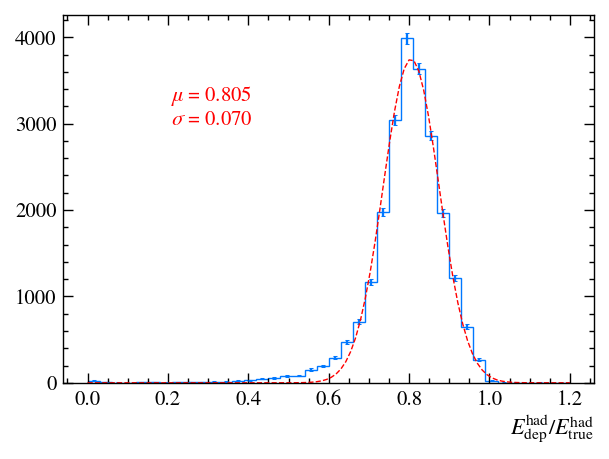

In [20]:
plt.figure(dpi=50)
h, b = np.histogram(numucc_deposited_had_E/numucc_true_had_E, bins=40, range=(0,1.2))
mplhep.histplot((h, b), label='numucc_had_cont', yerr=True, density=0)
plt.text(0.2,0.7,(r'$\mu$ = {:.3f}'+'\n'+'$\sigma$ = {:.3f}').format(fitResult.Parameter(1), fitResult.Parameter(2)),
         fontsize=30,color='r',transform=plt.gca().transAxes)
# add a 'best fit' line
y = norm.pdf(np.linspace(0,1.2,100), fitResult.Parameter(1), fitResult.Parameter(2))*fitResult.Parameter(0)*np.sqrt(2*3.1415926)*fitResult.Parameter(2)
l = plt.plot(np.linspace(0,1.2,100), y, 'r--', linewidth=2)

plt.gca().set_xlabel(r'$E_{\mathrm{dep}}^{\mathrm{had}}/E_{\mathrm{true}}^{\mathrm{had}}$')
plt.gcf().savefig('pics_numu/numucc_had_containment_1d.pdf')
plt.show()

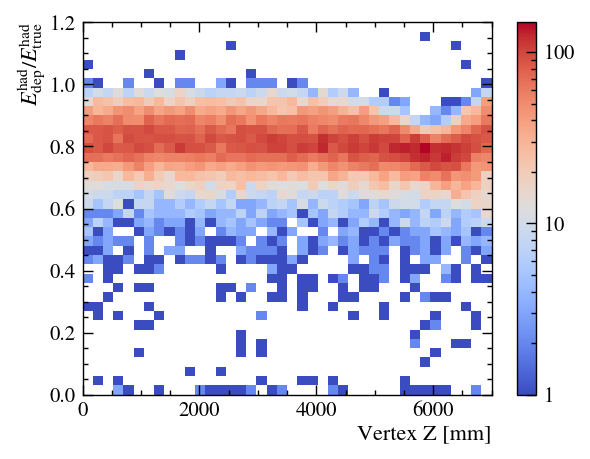

In [21]:
plt.figure(dpi=50)
plt.hist2d(df.query('nuPDG==14 and nuIntType==2 and prongIdx==1')['nuZ'], 
           numucc_deposited_had_E/numucc_true_had_E, 
           range=[[0,7000],[0,1.2]], bins=[40, 40], norm=mpl.colors.LogNorm(), cmap=plt.cm.coolwarm)
plt.gca().set_xlabel('Vertex Z [mm]')
plt.gca().set_ylabel(r'$E_{\mathrm{dep}}^{\mathrm{had}}/E_{\mathrm{true}}^{\mathrm{had}}$')
plt.colorbar()
plt.gcf().savefig('pics_numu/numucc_had_containment_2d.pdf')
plt.show()

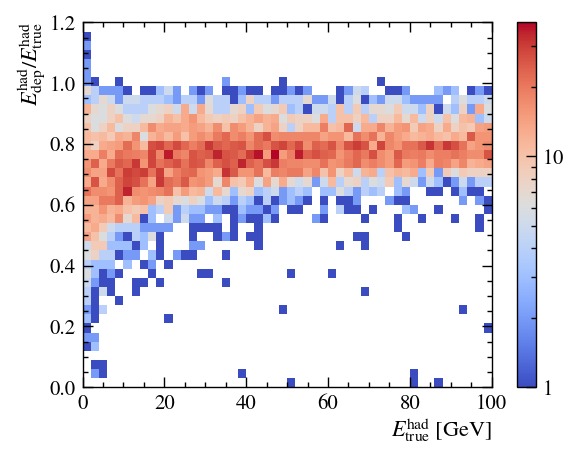

In [51]:
plt.figure(dpi=50)
plt.hist2d(numucc_true_had_E/1000, 
           numucc_deposited_had_E/numucc_true_had_E, 
           range=[[0,100],[0,1.2]], bins=[50, 40], norm=mpl.colors.LogNorm(), cmap=plt.cm.coolwarm)
plt.gca().set_xlabel(r'$E_{\mathrm{true}}^{\mathrm{had}}$ [GeV]')
plt.gca().set_ylabel(r'$E_{\mathrm{dep}}^{\mathrm{had}}/E_{\mathrm{true}}^{\mathrm{had}}$')
plt.colorbar()
#plt.gcf().savefig('pics_numu/numucc_had_containment_2d.pdf')
plt.show()

In [ ]:
tau_e_electron_P = df.query('prongType==1 and primaryTrackPDG==11')[['Px', 'Py', 'Pz']].to_numpy()
tau_e_tau_P = df.query('prongType==2 and primaryTrackPDG==15')[['Px', 'Py', 'Pz']].to_numpy()
tau_e_angle_e_tau = np.arccos((tau_e_electron_P*tau_e_tau_P).sum(1)/np.linalg.norm(tau_e_electron_P,axis=1)/np.linalg.norm(tau_e_tau_P,axis=1))

tau_mu_mu_P = df.query('prongType==3 and primaryTrackPDG==13')[['Px', 'Py', 'Pz']].to_numpy()
tau_mu_tau_P = df.query('prongType==4 and primaryTrackPDG==15')[['Px', 'Py', 'Pz']].to_numpy()
tau_mu_angle_mu_tau = np.arccos((tau_mu_mu_P*tau_mu_tau_P).sum(1)/np.linalg.norm(tau_mu_mu_P,axis=1)/np.linalg.norm(tau_mu_tau_P,axis=1))

tau_had_pi_df = df.query('prongType==5 and primaryTrackPDG==-211')
tau_had_pi_P = tau_had_pi_df[tau_had_pi_df['TrueP']==tau_had_pi_df.groupby('nuIdx')['TrueP'].transform(max)][['Px', 'Py', 'Pz']].to_numpy()
tau_had_tau_P = df.query('prongType==6 and primaryTrackPDG==15')[['Px', 'Py', 'Pz']].to_numpy()
tau_had_angle_pi_tau = np.arccos((tau_had_pi_P*tau_had_tau_P).sum(1)/np.linalg.norm(tau_had_pi_P,axis=1)/np.linalg.norm(tau_had_tau_P,axis=1))

plt.figure(dpi=50)
h, b = np.histogram(tau_e_angle_e_tau, bins=50, range=(0,0.06))
mplhep.histplot((h, b), label=r'$\tau_e$', yerr=True, density=0)

h, b = np.histogram(tau_mu_angle_mu_tau, bins=50, range=(0,0.06))
mplhep.histplot((h, b), label=r'$\tau_\mu$', yerr=True, density=0)

h, b = np.histogram(tau_had_angle_pi_tau, bins=50, range=(0,0.06))
mplhep.histplot((h, b), label=r'$\tau_{\mathrm{had}}$', yerr=True, density=0)

#plt.text(0.6,0.7,r'Mean: {:.2f}'.format(np.mean(tau_e_angle_e_tau)),
#         fontsize=30,transform=plt.gca().transAxes)
plt.gca().set_xlabel(r'Angle w.r.t $\tau$ for ($e,\mu,\pi^-$) [rad]')
plt.legend(loc='best', frameon=True)
plt.gcf().savefig('pics_nutau/nutau_cc_tau_decay_angle.pdf')
plt.show()

In [ ]:
plt.figure(dpi=50)
plot_comparisons_with_weights('LongestEInLAr', 'EInLAr of the longest prong [MeV]', 
                              [nuecc, numucc, nutau_e, nutau_mu, nutau_had, nc],
                              [r'$\nu_e$ CC', r'$\nu_\mu$ CC', r'$\tau_e\times300$', r'$\tau_\mu\times300$', r'$\tau_{\mathrm{had}}\times300$', 'NC'], 
                              [1, 1, 300, 300, 300, 1], [0, 3000], density=0) 
#plt.gcf().savefig('pics/LongestEInLAr.pdf')

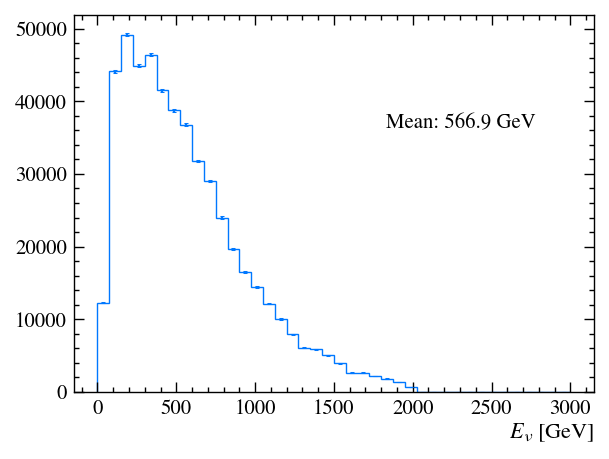

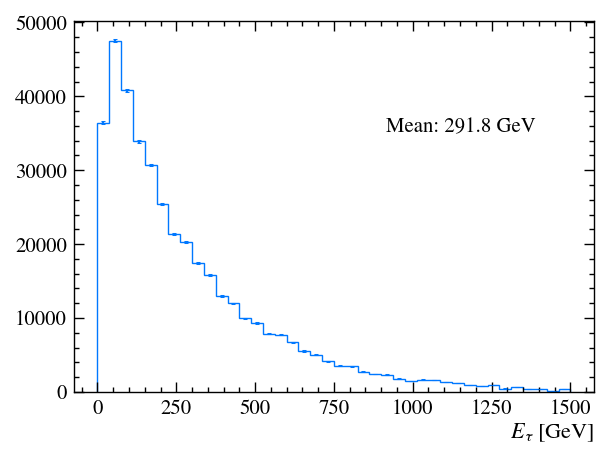

In [29]:
plt.figure(dpi=50)
h, b = np.histogram(df.query('nuPDG==16')['nuE'], bins=40, range=(0,3000))
mplhep.histplot((h, b), label='nuE', yerr=True, density=0)
plt.text(0.6,0.7,r'Mean: {:.1f} GeV'.format(np.mean(df.query('nuPDG==16')['nuE'])),fontsize=30,transform=plt.gca().transAxes)
plt.gca().set_xlabel(r'$E_\nu$ [GeV]')
plt.gcf().savefig('pics_nutau/nutau_nu_energy.pdf')
plt.show()

plt.figure(dpi=50)
h, b = np.histogram(df.query('nuPDG==16 & nuIntType==2')['nuFSLE'], bins=40, range=(0,1500))
mplhep.histplot((h, b), label='nuE', yerr=True, density=0)
plt.text(0.6,0.7,r'Mean: {:.1f} GeV'.format(np.mean(df.query('nuPDG==16 & nuIntType==2')['nuFSLE'])),fontsize=30,transform=plt.gca().transAxes)
plt.gca().set_xlabel(r'$E_\tau$ [GeV]')
plt.gcf().savefig('pics_nutau/nutau_tau_energy.pdf')
plt.show()

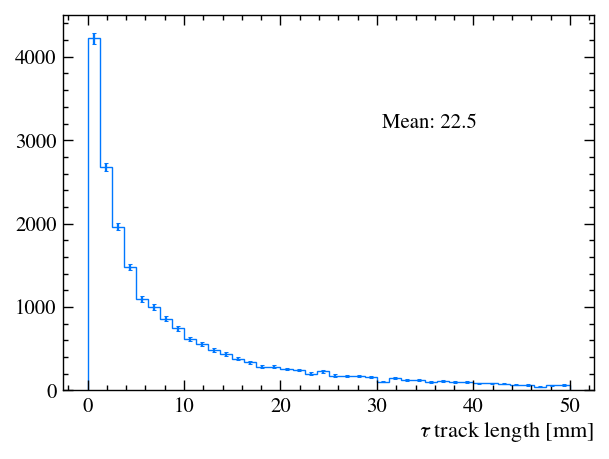

In [41]:
plt.figure(dpi=50)
h, b = np.histogram(df.query('nuPDG==16 and nuIntType==2 and primaryTrackID==1')['ShowerLength'], bins=40, range=(0,50))
mplhep.histplot((h, b), label='track_len', yerr=True, density=0)
plt.text(0.6,0.7,r'Mean: {:.1f}'.format(np.mean(df.query('nuPDG==16 and nuIntType==2 and primaryTrackID==1')['ShowerLength'])),
         fontsize=30,transform=plt.gca().transAxes)
plt.gca().set_xlabel(r'$\tau$ track length [mm]')
plt.gcf().savefig('pics_nutau/nutaucc_lepton_tracklength.pdf')
plt.show()


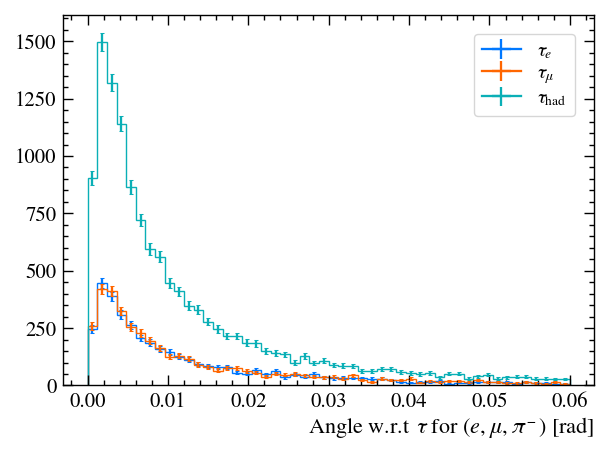

In [113]:
tau_e_electron_P = df.query('prongType==1 and primaryTrackPDG==11')[['Px', 'Py', 'Pz']].to_numpy()
tau_e_tau_P = df.query('prongType==2 and primaryTrackPDG==15')[['Px', 'Py', 'Pz']].to_numpy()
tau_e_angle_e_tau = np.arccos((tau_e_electron_P*tau_e_tau_P).sum(1)/np.linalg.norm(tau_e_electron_P,axis=1)/np.linalg.norm(tau_e_tau_P,axis=1))

tau_mu_mu_P = df.query('prongType==3 and primaryTrackPDG==13')[['Px', 'Py', 'Pz']].to_numpy()
tau_mu_tau_P = df.query('prongType==4 and primaryTrackPDG==15')[['Px', 'Py', 'Pz']].to_numpy()
tau_mu_angle_mu_tau = np.arccos((tau_mu_mu_P*tau_mu_tau_P).sum(1)/np.linalg.norm(tau_mu_mu_P,axis=1)/np.linalg.norm(tau_mu_tau_P,axis=1))

tau_had_pi_df = df.query('prongType==5 and primaryTrackPDG==-211')
tau_had_pi_P = tau_had_pi_df[tau_had_pi_df['TrueP']==tau_had_pi_df.groupby('nuIdx')['TrueP'].transform(max)][['Px', 'Py', 'Pz']].to_numpy()
tau_had_tau_P = df.query('prongType==6 and primaryTrackPDG==15')[['Px', 'Py', 'Pz']].to_numpy()
tau_had_angle_pi_tau = np.arccos((tau_had_pi_P*tau_had_tau_P).sum(1)/np.linalg.norm(tau_had_pi_P,axis=1)/np.linalg.norm(tau_had_tau_P,axis=1))

plt.figure(dpi=50)
h, b = np.histogram(tau_e_angle_e_tau, bins=50, range=(0,0.06))
mplhep.histplot((h, b), label=r'$\tau_e$', yerr=True, density=0)

h, b = np.histogram(tau_mu_angle_mu_tau, bins=50, range=(0,0.06))
mplhep.histplot((h, b), label=r'$\tau_\mu$', yerr=True, density=0)

h, b = np.histogram(tau_had_angle_pi_tau, bins=50, range=(0,0.06))
mplhep.histplot((h, b), label=r'$\tau_{\mathrm{had}}$', yerr=True, density=0)

#plt.text(0.6,0.7,r'Mean: {:.2f}'.format(np.mean(tau_e_angle_e_tau)),
#         fontsize=30,transform=plt.gca().transAxes)
plt.gca().set_xlabel(r'Angle w.r.t $\tau$ for ($e,\mu,\pi^-$) [rad]')
plt.legend(loc='best', frameon=True)
plt.gcf().savefig('pics_nutau/nutau_cc_tau_decay_angle.pdf')
plt.show()

In [7]:
df

Index(['nuIdx', 'nuPDG', 'nuX', 'nuY', 'nuZ', 'nuE', 'nuIntType',
       'nuScatteringType', 'nuFSLPDG', 'nuFSLE', 'nPrimaryParticle',
       'primaryTrackPDG', 'Px', 'Py', 'Pz', 'Pmass', 'VtxX', 'VtxY', 'VtxZ',
       'primaryParentID', 'primaryTrackID', 'prongType', 'EInLAr', 'EInHadCal',
       'EInMuonFinder', 'AngleToBeamDir', 'ShowerLength', 'ShowerLengthInLAr',
       'ShowerWidth', 'ShowerWidthInLAr', 'dEdx', 'dEdxInLAr', 'edepInLAr',
       'edepInHadCalX', 'edepInHadCalY', 'edepInMuonFinderX',
       'edepInMuonFinderY', 'edepInHadAborb', 'edepInMuonFinderAbsorb',
       'edepInCryGap', 'nFromFSLParticles', 'dir_pca_x', 'dir_pca_y',
       'dir_pca_z', 'dir_coc_x', 'dir_coc_y', 'dir_coc_z', 'uniqueid', 'TrueP',
       'edep_tot', 'edep_prong', 'fsl_EInLArFrac', 'nProng', 'prongIdx',
       'longestProng', 'longestProngIdx', 'leadingProng', 'leadingProngIdx',
       'Pt', 'PtP', 'PtEdep', 'num_piminus', 'num_piplus', 'num_pi0',
       'num_proton', 'num_neutron', 'num_kplus', 

In [ ]:
np.where(np.linalg.norm(df.query('primaryTrackPDG==13')[['dir_coc_x', 'dir_coc_y', 'dir_coc_z']].to_numpy(),axis=1)==0)

(array([23167, 23248, 23787, 23927, 24270, 24313, 25635, 26218, 26293,
        27057]),)

In [72]:
np.where(np.linalg.norm(df.query('primaryTrackPDG==-211')[['dir_coc_x', 'dir_coc_y', 'dir_coc_z']].to_numpy(),axis=1)==0)

(array([177472, 189866, 222830]),)

/home/wenjieww/app/anaconda3/envs/pyroot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wenjieww/app/anaconda3/envs/pyroot/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/wenjieww/app/anaconda3/envs/pyroot/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


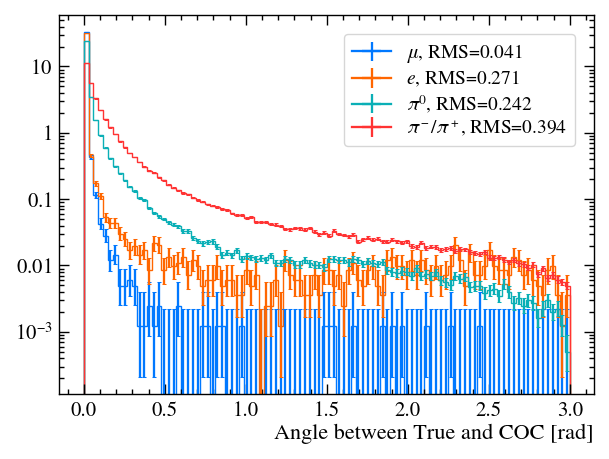

In [59]:
mu_true_P = df.query('primaryTrackPDG==13')[['Px', 'Py', 'Pz']].to_numpy()
mu_coc_dir = df.query('primaryTrackPDG==13')[['dir_coc_x', 'dir_coc_y', 'dir_coc_z']].to_numpy()
coc_angle_mu = np.arccos((mu_true_P*mu_coc_dir).sum(1)/np.linalg.norm(mu_true_P,axis=1)/np.linalg.norm(mu_coc_dir,axis=1))

e_true_P = df.query('primaryTrackPDG==11')[['Px', 'Py', 'Pz']].to_numpy()
e_coc_dir = df.query('primaryTrackPDG==11')[['dir_coc_x', 'dir_coc_y', 'dir_coc_z']].to_numpy()
coc_angle_e = np.arccos((e_true_P*e_coc_dir).sum(1)/np.linalg.norm(e_true_P,axis=1)/np.linalg.norm(e_coc_dir,axis=1))

pi0_true_P = df.query('primaryTrackPDG==111')[['Px', 'Py', 'Pz']].to_numpy()
pi0_coc_dir = df.query('primaryTrackPDG==111')[['dir_coc_x', 'dir_coc_y', 'dir_coc_z']].to_numpy()
coc_angle_pi0 = np.arccos((pi0_true_P*pi0_coc_dir).sum(1)/np.linalg.norm(pi0_true_P,axis=1)/np.linalg.norm(pi0_coc_dir,axis=1))

piminus_true_P = df.query('primaryTrackPDG==-211 | primaryTrackPDG==211')[['Px', 'Py', 'Pz']].to_numpy()
piminus_coc_dir = df.query('primaryTrackPDG==-211 | primaryTrackPDG==211')[['dir_coc_x', 'dir_coc_y', 'dir_coc_z']].to_numpy()
coc_angle_piminus = np.arccos((piminus_true_P*piminus_coc_dir).sum(1)/np.linalg.norm(piminus_true_P,axis=1)/np.linalg.norm(piminus_coc_dir,axis=1))

plt.figure(dpi=50)
lim_high = 3; nbins=100;
h, b = np.histogram(coc_angle_mu, bins=nbins, range=(0,lim_high))
mplhep.histplot((h, b), label=r'$\mu$, RMS={:.3f}'.format(np.std(coc_angle_mu, where=~np.isnan(coc_angle_mu))), yerr=True, density=1)
h, b = np.histogram(coc_angle_e, bins=nbins, range=(0,lim_high))
mplhep.histplot((h, b), label=r'$e$, RMS={:.3f}'.format(np.std(coc_angle_e, where=~np.isnan(coc_angle_e))), yerr=True, density=1)
h, b = np.histogram(coc_angle_pi0, bins=nbins, range=(0,lim_high))
mplhep.histplot((h, b), label=r'$\pi^0$, RMS={:.3f}'.format(np.std(coc_angle_pi0, where=~np.isnan(coc_angle_pi0))), yerr=True, density=1)
h, b = np.histogram(coc_angle_piminus, bins=nbins, range=(0,lim_high))
mplhep.histplot((h, b), label=r'$\pi^-/\pi^+$, RMS={:.3f}'.format(np.std(coc_angle_piminus, where=~np.isnan(coc_angle_piminus))), yerr=True, density=1)
plt.gca().set_xlabel(r'Angle between True and COC [rad]')
plt.gca().set_yscale('log')
plt.legend(loc='best', frameon=True)
#plt.gcf().savefig('pics/coc_angle_resolution.pdf')
plt.show()

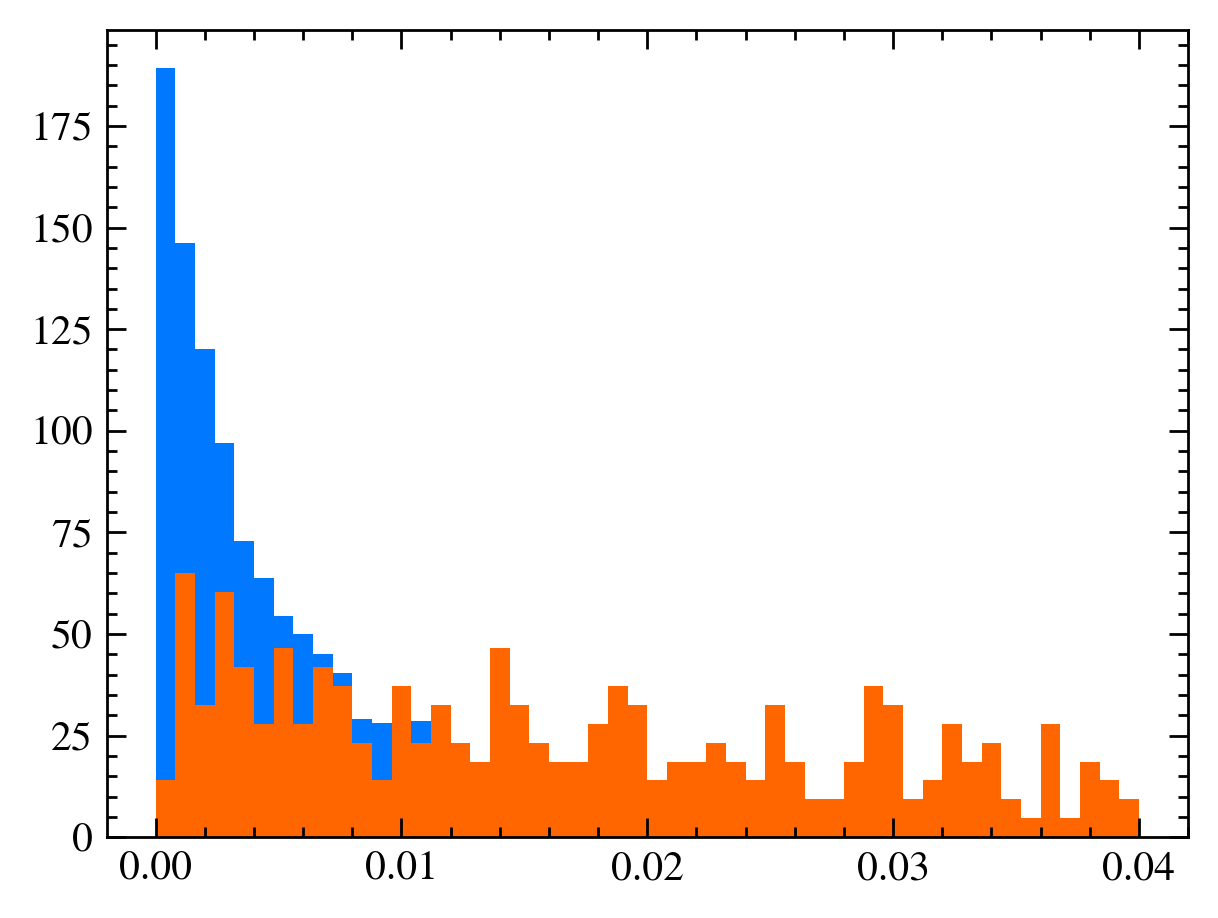

In [40]:
plt.hist(coc_angle_mu[~np.isnan(coc_angle_mu)]-np.mean(coc_angle_mu[~np.isnan(coc_angle_mu)]), bins=50, range=(0,0.04), density=1)
plt.hist(coc_angle_e[~np.isnan(coc_angle_e)]-np.mean(coc_angle_e[~np.isnan(coc_angle_e)]), bins=50, range=(0,0.04), density=1)

plt.show()

In [36]:
np.sqrt(np.sum((coc_angle_e[~np.isnan(coc_angle_e)]-np.mean(coc_angle_e[~np.isnan(coc_angle_e)]))**2)/27573)

0.27078345746668725

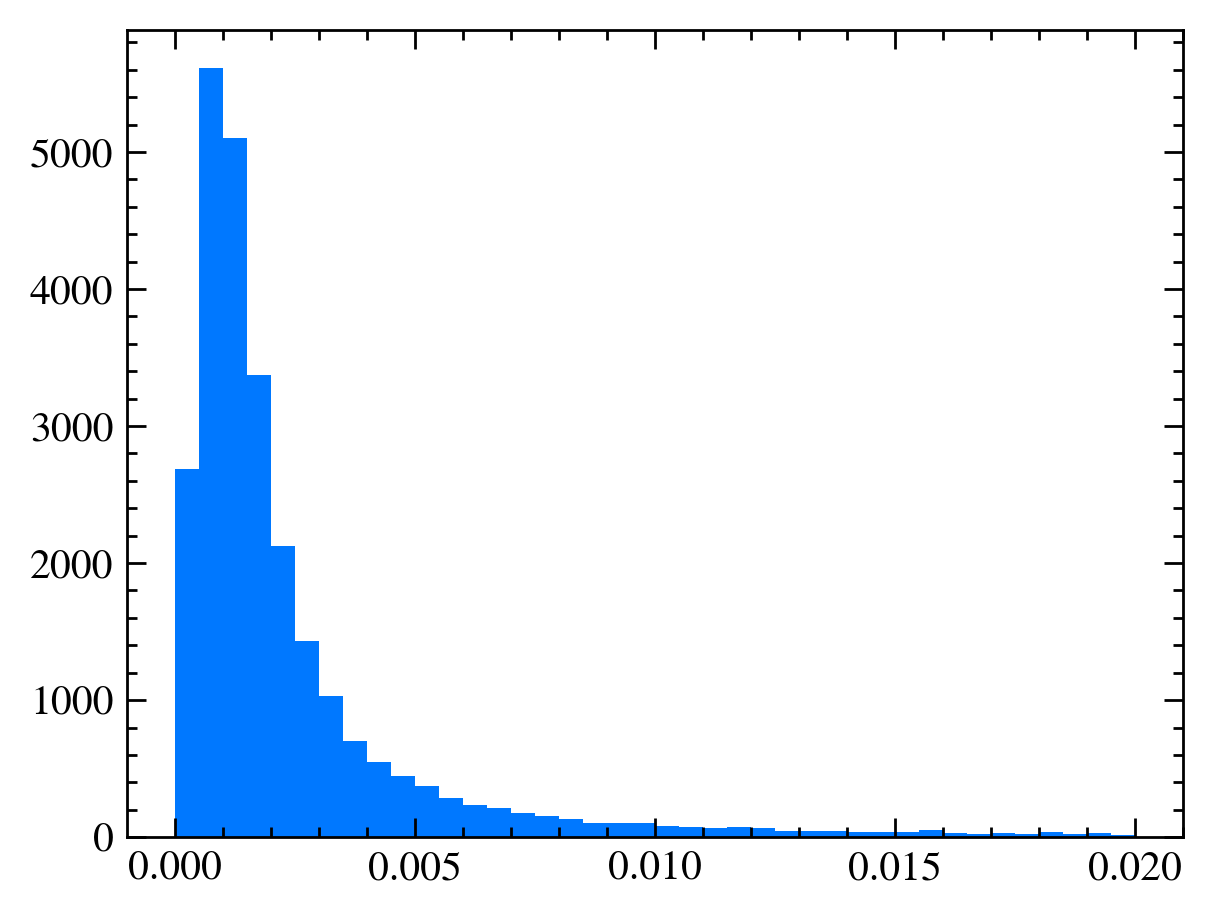

In [16]:
plt.hist(coc_angle_e, range=(0,0.02), bins=40)
plt.show()